In [5]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

#sklearn preprocessing

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


#Regression model

from sklearn.linear_model import LinearRegression,Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor



from sklearn.ensemble import VotingRegressor, StackingRegressor


#metrices

from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error

import warnings
warnings.filterwarnings("ignore")


In [4]:
df=pd.read_csv("student.csv")
df.head(10)

,date,gender,age,address,famsize,Pstatus,M_Edu,F_Edu,M_Job,F_Job,relationship,smoker,tuition_fee,time_friends,ssc_result,hsc_result
0,29/04/2018,M,18,Rural,GT3,Together,3,2,At_home,Farmer,No,No,71672,4,4.22,3.72
1,29/04/2018,F,19,Rural,LE3,Apart,0,4,Other,Health,Yes,No,26085,5,3.47,2.62
2,29/04/2018,F,19,Rural,GT3,Together,0,3,Teacher,Services,No,No,40891,3,3.32,2.56
3,29/04/2018,F,19,Rural,LE3,Apart,2,3,At_home,Business,No,No,50600,2,4.57,4.17
4,29/04/2018,M,17,Rural,GT3,Together,1,1,At_home,Farmer,No,No,62458,2,4.50,3.94
5,29/04/2018,M,18,Rural,GT3,Together,2,4,At_home,Farmer,No,Yes,43645,2,4.09,3.65
6,29/04/2018,M,18,Urban,GT3,Together,1,0,Teacher,Teacher,No,No,111578,1,3.46,2.99
7,29/04/2018,F,18,Rural,GT3,Together,2,1,Services,Teacher,Yes,No,76596,3,4.51,3.92
8,29/04/2018,F,17,Rural,GT3,Together,2,3,Other,Teacher,Yes,Yes,39874,3,3.26,2.59
9,29/04/2018,F,17,Rural,LE3,Together,2,2,Health,Health,No,No,48767,3,4.72,4.25


In [6]:
df.columns= [
    'date','st_gender','st_age','st_address',
    'st_fam_size','pstatus','m_edu','f_edu',
    'm_job','f_job','st_relationship',
    'smoker','tuition_fee','time_with_friends',
    'ssc_result','hsc_result'
]

In [7]:
if 'date' in df.columns:
  df.drop( columns = ['date'], inplace=True )

In [8]:
corr_target = df.select_dtypes(include=np.number).corr()['hsc_result'].sort_values(ascending=False)
print(corr_target)

hsc_result           1.000000
ssc_result           0.950178
m_edu                0.063776
f_edu                0.054811
tuition_fee          0.038068
st_age              -0.009857
time_with_friends   -0.156356
Name: hsc_result, dtype: float64


In [9]:
X = df.drop('hsc_result',axis=1)
y = df['hsc_result']

In [10]:
numeric_features = X.select_dtypes(include = ['int64','float64']).columns
categorical_features = X.select_dtypes(include = ['object']).columns

# Pipieline

In [11]:
#for numerical features

num_transformer = Pipeline (
    steps = [
        ('imputer',SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]
)

# For categorical Feture

In [12]:
cat_transformer = Pipeline( steps = [
    ('imputer',SimpleImputer(strategy='most_frequent')),
    ('encoder',OneHotEncoder(handle_unknown='ignore'))
] )

In [13]:
#combine them
preprocessor = ColumnTransformer(
    transformers= [
        ('num',num_transformer,numeric_features),
        ('cat',cat_transformer,categorical_features)
    ]
    )

In [14]:
#train test split
X_train,X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2 , random_state=42)

In [15]:
#base learner

reg_lr = LinearRegression()
reg_rf = RandomForestRegressor( n_estimators=100, random_state=42 )
reg_gb = GradientBoostingRegressor( n_estimators=100 , random_state=42 )

In [16]:
#Voting regressor

voting_reg = VotingRegressor(
    estimators= [
        ('lr', reg_lr),
        ('rf',reg_rf),
        ('gb', reg_gb)
    ]
)

In [17]:
#stacking

stacking_reg = StackingRegressor(
    estimators= [
        ('rf',reg_rf),
        ('gb', reg_gb)
    ],
    final_estimator= Ridge() #the meta learner
)


# Model training and Evaluation

In [18]:
#dictionary of all model

model_to_train = {
    'Linear Regression' : reg_lr,
    'Random Forest' : reg_rf,
    'Gradient Boosting': reg_gb,
    'Voting Ensemble ' : voting_reg,
    'Stacking Ensemble ' : stacking_reg

}

In [19]:
#training & Evaluation

result = []

for name , model in model_to_train.items():
  #create full pipeline with preprocessor
  pipe = Pipeline(
      [
          ('preprocessor', preprocessor),
          ('model',model)
      ]
  )

  #train

  pipe.fit(X_train,y_train)

  #predict

  y_pred = pipe.predict(X_test)

  #Evaluate

  r2 = r2_score(y_test,y_pred)
  rmse = np.sqrt(mean_squared_error(y_test,y_pred))
  mae = mean_absolute_error(y_test,y_pred)

  result.append({
      "Model": name,
      "R2 Score" :r2,
      "RMSE": rmse,
      "MAE" : mae
  })

results_df = pd.DataFrame(result).sort_values("R2 Score", ascending=False)

print(results_df)

                Model  R2 Score      RMSE       MAE
4  Stacking Ensemble   0.959566  0.123105  0.098696
2   Gradient Boosting  0.959565  0.123107  0.098902
3    Voting Ensemble   0.957528  0.126169  0.100838
1       Random Forest  0.950248  0.136556  0.108201
0   Linear Regression  0.945920  0.142371  0.111376


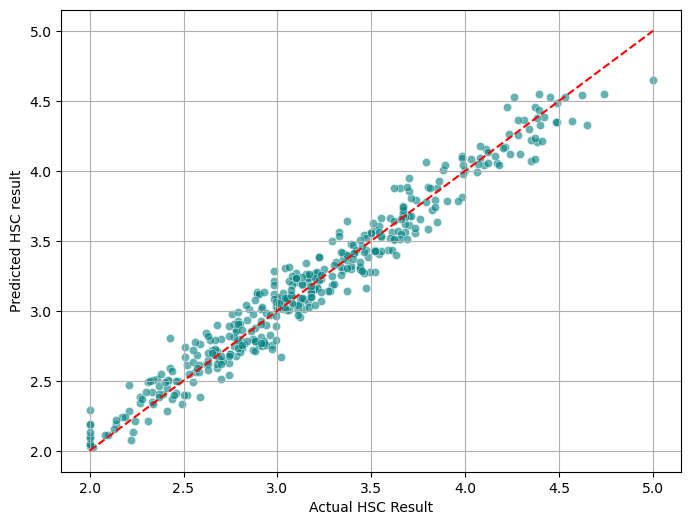

In [20]:
best_model_name = results_df.iloc[0]['Model']
best_model_obj = model_to_train[best_model_name]


#fit the best model

final_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model',best_model_obj)
])

final_pipe.fit(X_train,y_train)
y_final_pred = final_pipe.predict(X_test)


#plot Actual vs predicted

plt.figure( figsize = (8,6) )

sns.scatterplot(x=y_test, y=y_final_pred, alpha = 0.6, color='teal' )
plt.plot( [2,5] , [2,5], color = "red", linestyle = '--'  )

plt.xlabel("Actual HSC Result")
plt.ylabel("Predicted HSC result")

plt.grid(True)
plt.show()

# cross validation 

In [21]:
from sklearn.model_selection import cross_val_score

# Pipe line create we random forest 

In [29]:
rf_pipeline=Pipeline(
    [('preprocessor',preprocessor),
     ("model",RandomForestRegressor(n_estimators=100,random_state=42))
     
     ]

)

# Apply cross validation

In [30]:
#5 fold  cv
cv_scores=cross_val_score(rf_pipeline,
                          X_train,
                          y_train,
                          cv=5,
                          scoring='neg_mean_squared_error')
cv_rmse=np.sqrt(-cv_scores)

In [31]:
print(cv_rmse)

[0.13825617 0.14202924 0.15369812 0.14773708 0.12940278]


In [32]:
print(cv_rmse.mean())

0.14222467953735998


# stacking  pipeline

In [35]:
stacking_pipeline=Pipeline(
    [('preprocessor',preprocessor),
     ("model",stacking_reg)
     
     ]

)

In [37]:
#5 fold  cv
cv_scores=cross_val_score(stacking_pipeline,
                          X_train,
                          y_train,
                          cv=5,
                          n_jobs=-1,#use  all processor core , to spreed up
                          scoring='neg_mean_squared_error')
stacking_rmse=np.sqrt(-cv_scores)
print(stacking_rmse)

[0.12742194 0.1342731  0.13336693 0.13391606 0.11927744]


# grid_Search CV

In [46]:
rf_pipeline=Pipeline(
    [('preprocessor',preprocessor),
     ("model",RandomForestRegressor(n_estimators=100,random_state=42))
     
     ]

)

In [49]:
#define the grid

#define the grid

param_grid = {
    'model__n_estimators' : [100,200] ,
    'model__max_depth': [None,10,20],
    'model__min_samples_split' : [2,5]
}

In [50]:
from sklearn.model_selection import GridSearchCV

GridSearch=GridSearchCV(
    estimator=rf_pipeline,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=2
)

In [51]:
GridSearch.fit(X_train,y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['st_age', 'm_edu', 'f_edu', 'tuition_fee', 'time_with_friends',
       'ssc_result'],
      dtype='object')),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_...
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         Index(['st_gender', 'st_address', 'st_fam_size', 'pstatus', 'm_job', 'f_job',
       'st_relationship', 'smoker'],
      dtype='object'))])),
                                       ('model',
                                        RandomForestRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'model__max_depth': [None, 10, 20],
                         'model__min_samples_split': [2, 5],
                         'model__n_estimators': [100, 200]},
             scoring='neg_root_mean_squared_error', verbose=2)

In [52]:
print(GridSearch.best_score_)

-0.14145800733122194


In [53]:
print(GridSearch.best_params_)

{'model__max_depth': 10, 'model__min_samples_split': 2, 'model__n_estimators': 200}


# Randomized Search CV

In [57]:
from scipy.stats import randint

my_dist= randint(1,10)

print(my_dist.rvs())
print(my_dist.rvs())
print(my_dist.rvs())# proti bar amader code run korle new digit dibe which is 
#  between 1 to 10 digit number 

2
9
9


# define parameter for randomized CV

In [58]:

param_dist = {
    'model__n_estimators' :randint(100,500) ,
    'model__max_depth': [None,10,20],
    'model__min_samples_split' :randint(1,10)
}

In [61]:
from sklearn.model_selection import RandomizedSearchCV

randomSearch=RandomizedSearchCV(
    estimator=rf_pipeline,
    param_distributions=param_dist,
    n_iter=50,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=2,
    random_state= 42
)

In [62]:
randomSearch.fit(X_train,y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               Index(['st_age', 'm_edu', 'f_edu', 'tuition_fee', 'time_with_friends',
       'ssc_result'],
      dtype='object')),
                                                                              ('cat',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy=...
                                              RandomForestRegressor(random_state=42))]),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'model__max_depth': [None, 10, 20],
                                        'model__min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000277C29C5FD0>,
                                        'model__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000277C3CF63F0>},
                   random_state=42, scoring='neg_root_mean_squared_error',
                   verbose=2)

In [65]:
print(-randomSearch.best_score_)

0.14083631874723837


In [77]:
randomSearch.predict(X_test)

array([3.24813808, 3.63936138, 3.69632315, 3.93415944, 4.1076736 ,
       3.27072695, 4.09958465, 2.50256598, 2.10633699, 3.2701777 ,
       3.57431522, 2.92584264, 3.19929278, 4.51298167, 3.01386118,
       2.63695208, 3.61628147, 3.36786373, 2.87122621, 2.88735632,
       2.74107849, 3.18588724, 2.89945616, 3.22534203, 2.05461314,
       2.64539077, 3.21802007, 4.03430123, 3.1203105 , 4.08801523,
       2.45744916, 3.83485003, 4.50888024, 2.56348902, 3.20317019,
       3.21390665, 2.74812963, 3.57604872, 2.45020837, 2.60565241,
       2.98895371, 2.97619076, 3.66365835, 2.76651367, 2.32610757,
       3.01739181, 2.61563775, 2.70441272, 4.1070183 , 3.22731134,
       3.00102886, 3.40829784, 4.236945  , 3.53883388, 2.99426729,
       3.23744524, 3.25401752, 2.78525418, 3.71359346, 2.7038779 ,
       3.03148646, 2.65733352, 2.5149602 , 4.43089257, 2.58082166,
       3.21989986, 3.86168574, 2.73406531, 3.04757297, 3.23642417,
       3.01372702, 2.62950665, 2.70293356, 3.43821656, 3.04831

In [66]:
print(randomSearch.best_params_)

{'model__max_depth': 10, 'model__min_samples_split': 4, 'model__n_estimators': 369}


# Model save with pickling


In [71]:
import pickle
from sklearn.linear_model import LinearRegression

X_train_lr = [ [1],[2],[3],[4],[5] ]  #study
y_train_lr = [10,20,30,40,50] #marks

model = LinearRegression()

model.fit(X_train_lr,y_train_lr)

LinearRegression()

In [72]:
model.predict([[6]])[0]

np.float64(60.00000000000001)

In [73]:
filename = "model.pkl"

with open( filename, "wb" ) as file:
  pickle.dump( model, file )

Here our model is save now  next day we load this file and run our model 

In [74]:
#next day
with open("D:\ML_Project\project\model.pkl","rb") as file:
    loaded_model =pickle.load(file)


In [76]:
# now we predict this model

model.predict([[7]])[0]

np.float64(70.0)

# random forest model save this model

In [78]:
filename = "random_forest_model.pkl"

with open( filename, "wb" ) as file:
  pickle.dump( randomSearch, file )

# MLFlow to maintain the overall

In [ ]:
#!pip install mlflow

In [ ]:
#import mlflow

# mlflow.set_tracking_uri("file:///content/mlruns")
# mlflow.set_experiment("test_run")

# with mlflow.start_run( run_name = "Dummy_test" ):

#   #metric
#   mlflow.log_metric( "Accuracy", 0.95 )
#   mlflow.log_metric( "Loss", 0.05 )

#   #parameter

#   mlflow.log_param("model_type","fake_model_v1")
#   mlflow.log_param("Learning Rate",0.001)

# colab link too see overall Random forest overflow

https://colab.research.google.com/drive/1pHIx6ma0URqy83HNnAmgGBK2brckKNrs?usp=sharing